# Deep Neural Networks

In [ ]:
import pandas
import keras
import tensorflow as tf
import sklearn
import numpy
import matplotlib.pyplot as plt
import os
import seaborn

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

pandas.options.display.max_columns = None

# Start loading the data
The data is in csv file format, so we need to use `pandas.load_csv()` to load the spreadsheet. Additionally all the historical data has to be concatanated together to be a single table.

## Testing and training data
All the FbRef data from 2024 has to be taken as the testing data, and everything else is training data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
raw = pandas.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/Cleaned_Historical_Data.csv"
)
print("Raw data Shape: ", raw.shape)
raw.head()

Raw data Shape:  (2636, 272)


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HPossessionPercent,HNonPenaltyGoals,HPenaltyKicksMade,HPenaltyKicksAttempted,HPenaltyKicksMissed,HPassesCompleted_All,HPassesAttempted_All,HPassCompletion_All,HKeyPasses,H1/3,HPassesIntoPenaltyArea,HCrossesIntoPenaltyArea,HProgressivePasses,HTotalPassDistance,HProgressivePassDistance,HPassesCompleted_5to15yds,HPassesAttempted_5to15yds,HPassCompletion_5to15yds,HPassesCompleted_15to30yds,HPassesAttempted_15to30yds,HPassCompletion_15to30yds,HPassesCompleted_Over30yds,HPassesAttempted_Over30yds,HPassCompletion_Over30yds,HShotCreatingActions,HLiveBallPassesLeadingToShot,HDeadBallPassesLeadingToShot,HTakeOnsLeadingToShot,HShotsLeadingToAnotherShot,HFoulsDrawnLeadingToShot,HDefensiveActionsLeadingToShot,HGoalsScoredAllowed,HTotalShots,HShotsOnTarget,HShotsFromFreeKicks,HTkl,HTklW,HDef 3rd,HMid 3rd,HAtt 3rd,HTklD,Hatt,HTkl%,HLost,HBlocks,HShS,HPass,HInt,HTkl+Int,HClr,HErr,HGCA,HPassLive,HPassDead,HTOG,HShG,HFld,Hdef,HAttD,HSucc,HSucc%,HTkld,HTkld%,HxG,HnpxG,HxGD,HnpxGD,HxAG,HxA,HG-xG,Hnp:G-xG,HA-xAG,HxSh,HSoT,HFK,HRec,HPrgR,HCarries,HTotDist,HPrgDist,HPrgC,H1/3_2,HCPA,HMis,HDis,HTouches,HDef Pen,HDef 3rdT,HMid 3rdT,HAtt 3rdT,HAtt Pen,HLive,HSubs,HAtt (GK),HThr,HLaunch%,HAvgLen,HPKA,HFKA,HCK,HOG,HPKatt,HPKAT,HPKsv,HPKm,HSoTA,HSaves,Hlives,HDead,HFKF,HTB,HSw,HCrs,HTI,HCKs,HIn,HOut,HStr,HOff,Hblock,HPSxG,HPSxG+/-,HWon,Hlosts,HWon%,APossessionPercent,ANonPenaltyGoals,APenaltyKicksMade,APenaltyKicksAttempted,APenaltyKicksMissed,APassesCompleted_All,APassesAttempted_All,APassCompletion_All,AKeyPasses,A1/3,APassesIntoPenaltyArea,ACrossesIntoPenaltyArea,AProgressivePasses,ATotalPassDistance,AProgressivePassDistance,APassesCompleted_5to15yds,APassesAttempted_5to15yds,APassCompletion_5to15yds,APassesCompleted_15to30yds,APassesAttempted_15to30yds,APassCompletion_15to30yds,APassesCompleted_Over30yds,APassesAttempted_Over30yds,APassCompletion_Over30yds,AShotCreatingActions,ALiveBallPassesLeadingToShot,ADeadBallPassesLeadingToShot,ATakeOnsLeadingToShot,AShotsLeadingToAnotherShot,AFoulsDrawnLeadingToShot,ADefensiveActionsLeadingToShot,AGoalsScoredAllowed,ATotalShots,AShotsOnTarget,AShotsFromFreeKicks,ATkl,ATklW,ADef 3rd,AMid 3rd,AAtt 3rd,ATklD,AAttD,ATkl%,ALost,ABlocks,AShS,APass,AInt,ATkl+Int,AClr,AErr,AGCA,APassLive,APassDead,ATOG,AShG,Afld,Adef,AAttD.1,ASucc,ASucc%,ATkld,ATkld%,AxG,AnpxG,AxGD,AnpxGD,AxAG,AxA,AG-xG,Anp:G-xG,AA-xAG,AxSh,ASoT,AFK,ARec,APrgR,ACarries,ATotDist,APrgDist,APrgC,A1/3_2,ACPA,AMis,ADis,ATouches,ADef Pen,ADef 3rdT,AMid 3rdT,AAtt 3rdT,AAtt Pen,ALive,ASubs,AAtt (GK),AThr,ALaunch%,AAvgLen,APKA,AFKA,ACK,AOG,APKatt,APKAT,APKsv,APKm,ASoTA,ASaves,Alives,ADead,AFKF,ATB,ASw,ACrs,ATI,ACKs,AIn,AOut,AStr,AOff,Ablock,APSxG,APSxG+/-,AWon,Alosts,AWon%
0,10/01/2017,Arsenal,Brighton,2,0,H,1,0,H,K Friend,25,9,12,1,7,8,6,5,0,2,0,0,64,2,0,0,0,636,734,86.6,18,48,15,0,65,9954,3014,324,352,92.0,255,284,89.8,38,59,64.4,40,26,3,4,5,2,0,2,25,8,2,15,11,10,3,2,8,18,44.4,10,10,3,7,11,26,20,0,3,1,0,1,1,0,0,13,10,76.9,3,23.1,2.4,2.4,2.0,2.0,2.0,1.8,-0.4,-0.4,-1.0,25,8,2,636,65,582,2828,1595,31,38,6,18,7,831,52,150,397,290,39,831,3,19,6,10.5,27.7,0,0,0,0,0,0,0,0,1,1,693,39,9,1,3,12,17,6,4,0,0,2,9,0.1,0.1,30,13,69.8,36,0,0,0,0,299,410,72.9,7,20,6,2,31,5090,2008,138,151,91.4,108,140,77.1,31,82,37.8,17,10,3,2,0,1,1,0,9,1,0,10,6,9,1,0,3,13,23.1,10,16,9,7,19,29,24,1,0,0,0,0,0,0,0,18,10,55.6,8,44.4,0.4,0.4,-2.0,-2.0,0.3,0.4,-0.4,-0.4,-0.3,9,1,0,298,31,255,1530,722,16,15,3,8,7,507,90,214,179,121,15,507,3,25,6,52.0,40.7,0,0,0,0,0,0,0,0,8,6,351,56,8,0,4,18,26,5,5,0,0,3,8,2.7,0.7,13,30,30.2
1,10/01/2017,Everton,Burnley,0,1,A,0,1,A,J Moss,23,5,4,2,14,7,9,3,2,2,0,0,63,0,0,0,0,421,554,76.0,20,47,15,6,59,8069,2864,162,190,85.3,194,225,86.2,55,113,48.7,49,47,1,0,0,1,0,0,25,4,0,8,5,6,1,1,2,9,22.2,7,9,2,7,4,12,44,0,0,0,0,0,0,0,0,13,7,53.8,6,46.2,1.1,1.1,0.7,0.7,0.9,1.8,-1.1,-1.1,-0.9,25,4,0,418,59,344,2357,1354,35,26,10,11,12,671,50,176,273,231,40,671,3,29,3,62.1,50.1,0,0,0,0,

In [ ]:
data = pandas.DataFrame()

categorical_columns = ["HomeTeam", "AwayTeam"]
unimportant_columns = ["Div", "FTHG", "FTAG", "HTHG", "HTAG", "HTR", "Referee", 'HSave%', 'ASave%', "Date", "FTR"]

# Everything else is a numerical column
numerical_columns = [
    column
    for column in raw.columns.values
    if column not in categorical_columns + unimportant_columns
]

# One-hot encode the categorical columns
data = pandas.concat([data] + [pandas.get_dummies(raw[column], prefix=column) for column in categorical_columns], axis=1)

# Add the numerical columns
data = pandas.concat([data] + [raw[column] for column in numerical_columns], axis=1)

data["Date"] = pandas.to_datetime(raw["Date"], dayfirst=True)
Y_variables = "FTR"
data[Y_variables] = raw[Y_variables]

# Test train validation split
# Sort data based on date
data = data.sort_values("Date")

data.head()

<ipython-input-6-c550ff663821>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["Date"] = pandas.to_datetime(raw["Date"], dayfirst=True)
<ipython-input-6-c550ff663821>:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[Y_variables] = raw[Y_variables]


,HomeTeam_Arsenal,HomeTeam_Aston Villa,HomeTeam_Bournemouth,HomeTeam_Brentford,HomeTeam_Brighton,HomeTeam_Burnley,HomeTeam_Cardiff,HomeTeam_Chelsea,HomeTeam_Crystal Palace,HomeTeam_Everton,HomeTeam_Fulham,HomeTeam_Huddersfield,HomeTeam_Leeds,HomeTeam_Leicester,HomeTeam_Liverpool,HomeTeam_Luton,HomeTeam_Man City,HomeTeam_Man United,HomeTeam_Newcastle,HomeTeam_Norwich,HomeTeam_Nott'm Forest,HomeTeam_Sheffield United,HomeTeam_Southampton,HomeTeam_Stoke,HomeTeam_Swansea,HomeTeam_Tottenham,HomeTeam_Watford,HomeTeam_West Brom,HomeTeam_West Ham,HomeTeam_Wolves,AwayTeam_Arsenal,AwayTeam_Aston Villa,AwayTeam_Bournemouth,AwayTeam_Brentford,AwayTeam_Brighton,AwayTeam_Burnley,AwayTeam_Cardiff,AwayTeam_Chelsea,AwayTeam_Crystal Palace,AwayTeam_Everton,AwayTeam_Fulham,AwayTeam_Huddersfield,AwayTeam_Leeds,AwayTeam_Leicester,AwayTeam_Liverpool,AwayTeam_Luton,AwayTeam_Man City,AwayTeam_Man United,AwayTeam_Newcastle,AwayTeam_Norwich,AwayTeam_Nott'm Forest,AwayTeam_Sheffield United,AwayTeam_Southampton,AwayTeam_Stoke,AwayTeam_Swansea,AwayTeam_Tottenham,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wolves,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HPossessionPercent,HNonPenaltyGoals,HPenaltyKicksMade,HPenaltyKicksAttempted,HPenaltyKicksMissed,HPassesCompleted_All,HPassesAttempted_All,HPassCompletion_All,HKeyPasses,H1/3,HPassesIntoPenaltyArea,HCrossesIntoPenaltyArea,HProgressivePasses,HTotalPassDistance,HProgressivePassDistance,HPassesCompleted_5to15yds,HPassesAttempted_5to15yds,HPassCompletion_5to15yds,HPassesCompleted_15to30yds,HPassesAttempted_15to30yds,HPassCompletion_15to30yds,HPassesCompleted_Over30yds,HPassesAttempted_Over30yds,HPassCompletion_Over30yds,HShotCreatingActions,HLiveBallPassesLeadingToShot,HDeadBallPassesLeadingToShot,HTakeOnsLeadingToShot,HShotsLeadingToAnotherShot,HFoulsDrawnLeadingToShot,HDefensiveActionsLeadingToShot,HGoalsScoredAllowed,HTotalShots,HShotsOnTarget,HShotsFromFreeKicks,HTkl,HTklW,HDef 3rd,HMid 3rd,HAtt 3rd,HTklD,Hatt,HTkl%,HLost,HBlocks,HShS,HPass,HInt,HTkl+Int,HClr,HErr,HGCA,HPassLive,HPassDead,HTOG,HShG,HFld,Hdef,HAttD,HSucc,HSucc%,HTkld,HTkld%,HxG,HnpxG,HxGD,HnpxGD,HxAG,HxA,HG-xG,Hnp:G-xG,HA-xAG,HxSh,HSoT,HFK,HRec,HPrgR,HCarries,HTotDist,HPrgDist,HPrgC,H1/3_2,HCPA,HMis,HDis,HTouches,HDef Pen,HDef 3rdT,HMid 3rdT,HAtt 3rdT,HAtt Pen,HLive,HSubs,HAtt (GK),HThr,HLaunch%,HAvgLen,HPKA,HFKA,HCK,HOG,HPKatt,HPKAT,HPKsv,HPKm,HSoTA,HSaves,Hlives,HDead,HFKF,HTB,HSw,HCrs,HTI,HCKs,HIn,HOut,HStr,HOff,Hblock,HPSxG,HPSxG+/-,HWon,Hlosts,HWon%,APossessionPercent,ANonPenaltyGoals,APenaltyKicksMade,APenaltyKicksAttempted,APenaltyKicksMissed,APassesCompleted_All,APassesAttempted_All,APassCompletion_All,AKeyPasses,A1/3,APassesIntoPenaltyArea,ACrossesIntoPenaltyArea,AProgressivePasses,ATotalPassDistance,AProgressivePassDistance,APassesCompleted_5to15yds,APassesAttempted_5to15yds,APassCompletion_5to15yds,APassesCompleted_15to30yds,APassesAttempted_15to30yds,APassCompletion_15to30yds,APassesCompleted_Over30yds,APassesAttempted_Over30yds,APassCompletion_Over30yds,AShotCreatingActions,ALiveBallPassesLeadingToShot,ADeadBallPassesLeadingToShot,ATakeOnsLeadingToShot,AShotsLeadingToAnotherShot,AFoulsDrawnLeadingToShot,ADefensiveActionsLeadingToShot,AGoalsScoredAllowed,ATotalShots,AShotsOnTarget,AShotsFromFreeKicks,ATkl,ATklW,ADef 3rd,AMid 3rd,AAtt 3rd,ATklD,AAttD,ATkl%,ALost,ABlocks,AShS,APass,AInt,ATkl+Int,AClr,AErr,AGCA,APassLive,APassDead,ATOG,AShG,Afld,Adef,AAttD.1,ASucc,ASucc%,ATkld,ATkld%,AxG,AnpxG,AxGD,AnpxGD,AxAG,AxA,AG-xG,Anp:G-xG,AA-xAG,AxSh,ASoT,AFK,ARec,APrgR,ACarries,ATotDist,APrgDist,APrgC,A1/3_2,ACPA,AMis,ADis,ATouches,ADef Pen,ADef 3rdT,AMid 3rdT,AAtt 3rdT,AAtt Pen,ALive,ASubs,AAtt (GK),AThr,ALaunch%,AAvgLen,APKA,AFKA,ACK,AOG,APKatt,APKAT,APKsv,APKm,ASoTA,ASaves,Alives,ADead,AFKF,ATB,ASw,ACrs,ATI,ACKs,AIn,AOut,AStr,AOff,Ablock,APSxG,APSxG+/-,AWon,Alosts,AWon%,Date,FTR
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [ ]:
raw.drop(["FTHG", "FTAG", "HTHG", "HTAG", "HTR", "Referee", "Date", "FTR"], axis=1).columns.values

array(['HomeTeam', 'AwayTeam', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC',
       'AC', 'HY', 'AY', 'HR', 'AR', 'HPossessionPercent',
       'HNonPenaltyGoals', 'HPenaltyKicksMade', 'HPenaltyKicksAttempted',
       'HPenaltyKicksMissed', 'HPassesCompleted_All',
       'HPassesAttempted_All', 'HPassCompletion_All', 'HKeyPasses',
       'H1/3', 'HPassesIntoPenaltyArea', 'HCrossesIntoPenaltyArea',
       'HProgressivePasses', 'HTotalPassDistance',
       'HProgressivePassDistance', 'HPassesCompleted_5to15yds',
       'HPassesAttempted_5to15yds', 'HPassCompletion_5to15yds',
       'HPassesCompleted_15to30yds', 'HPassesAttempted_15to30yds',
       'HPassCompletion_15to30yds', 'HPassesCompleted_Over30yds',
       'HPassesAttempted_Over30yds', 'HPassCompletion_Over30yds',
       'HShotCreatingActions', 'HLiveBallPassesLeadingToShot',
       'HDeadBallPassesLeadingToShot', 'HTakeOnsLeadingToShot',
       'HShotsLeadingToAnotherShot', 'HFoulsDrawnLeadingToShot',
       'HDefensiveActionsLeading

In [ ]:
# 2024 data is test, 2023 is validation, everything else is train (drop Date column)
X_train = data[data["Date"].dt.year < 2022].drop(columns=["Date"])
Y_train = keras.utils.to_categorical(X_train[Y_variables].map({"H": 0, "D": 1, "A": 2}).to_numpy())
X_train = X_train.drop(columns=[Y_variables])

X_val = data[data["Date"].dt.year == 2022].drop(columns=["Date"])
Y_val = keras.utils.to_categorical(X_val[Y_variables].map({"H": 0, "D": 1, "A": 2}).to_numpy())
X_val = X_val.drop(columns=[Y_variables])

X_test = data[data["Date"].dt.year > 2022].drop(columns=["Date"])
Y_test = keras.utils.to_categorical(X_test[Y_variables].map({"H": 0, "D": 1, "A": 2}).to_numpy())
X_test = X_test.drop(columns=[Y_variables])


# Shape of the data
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

(1703, 322)
(361, 322)
(572, 322)
(1703, 3)
(361, 3)
(572, 3)


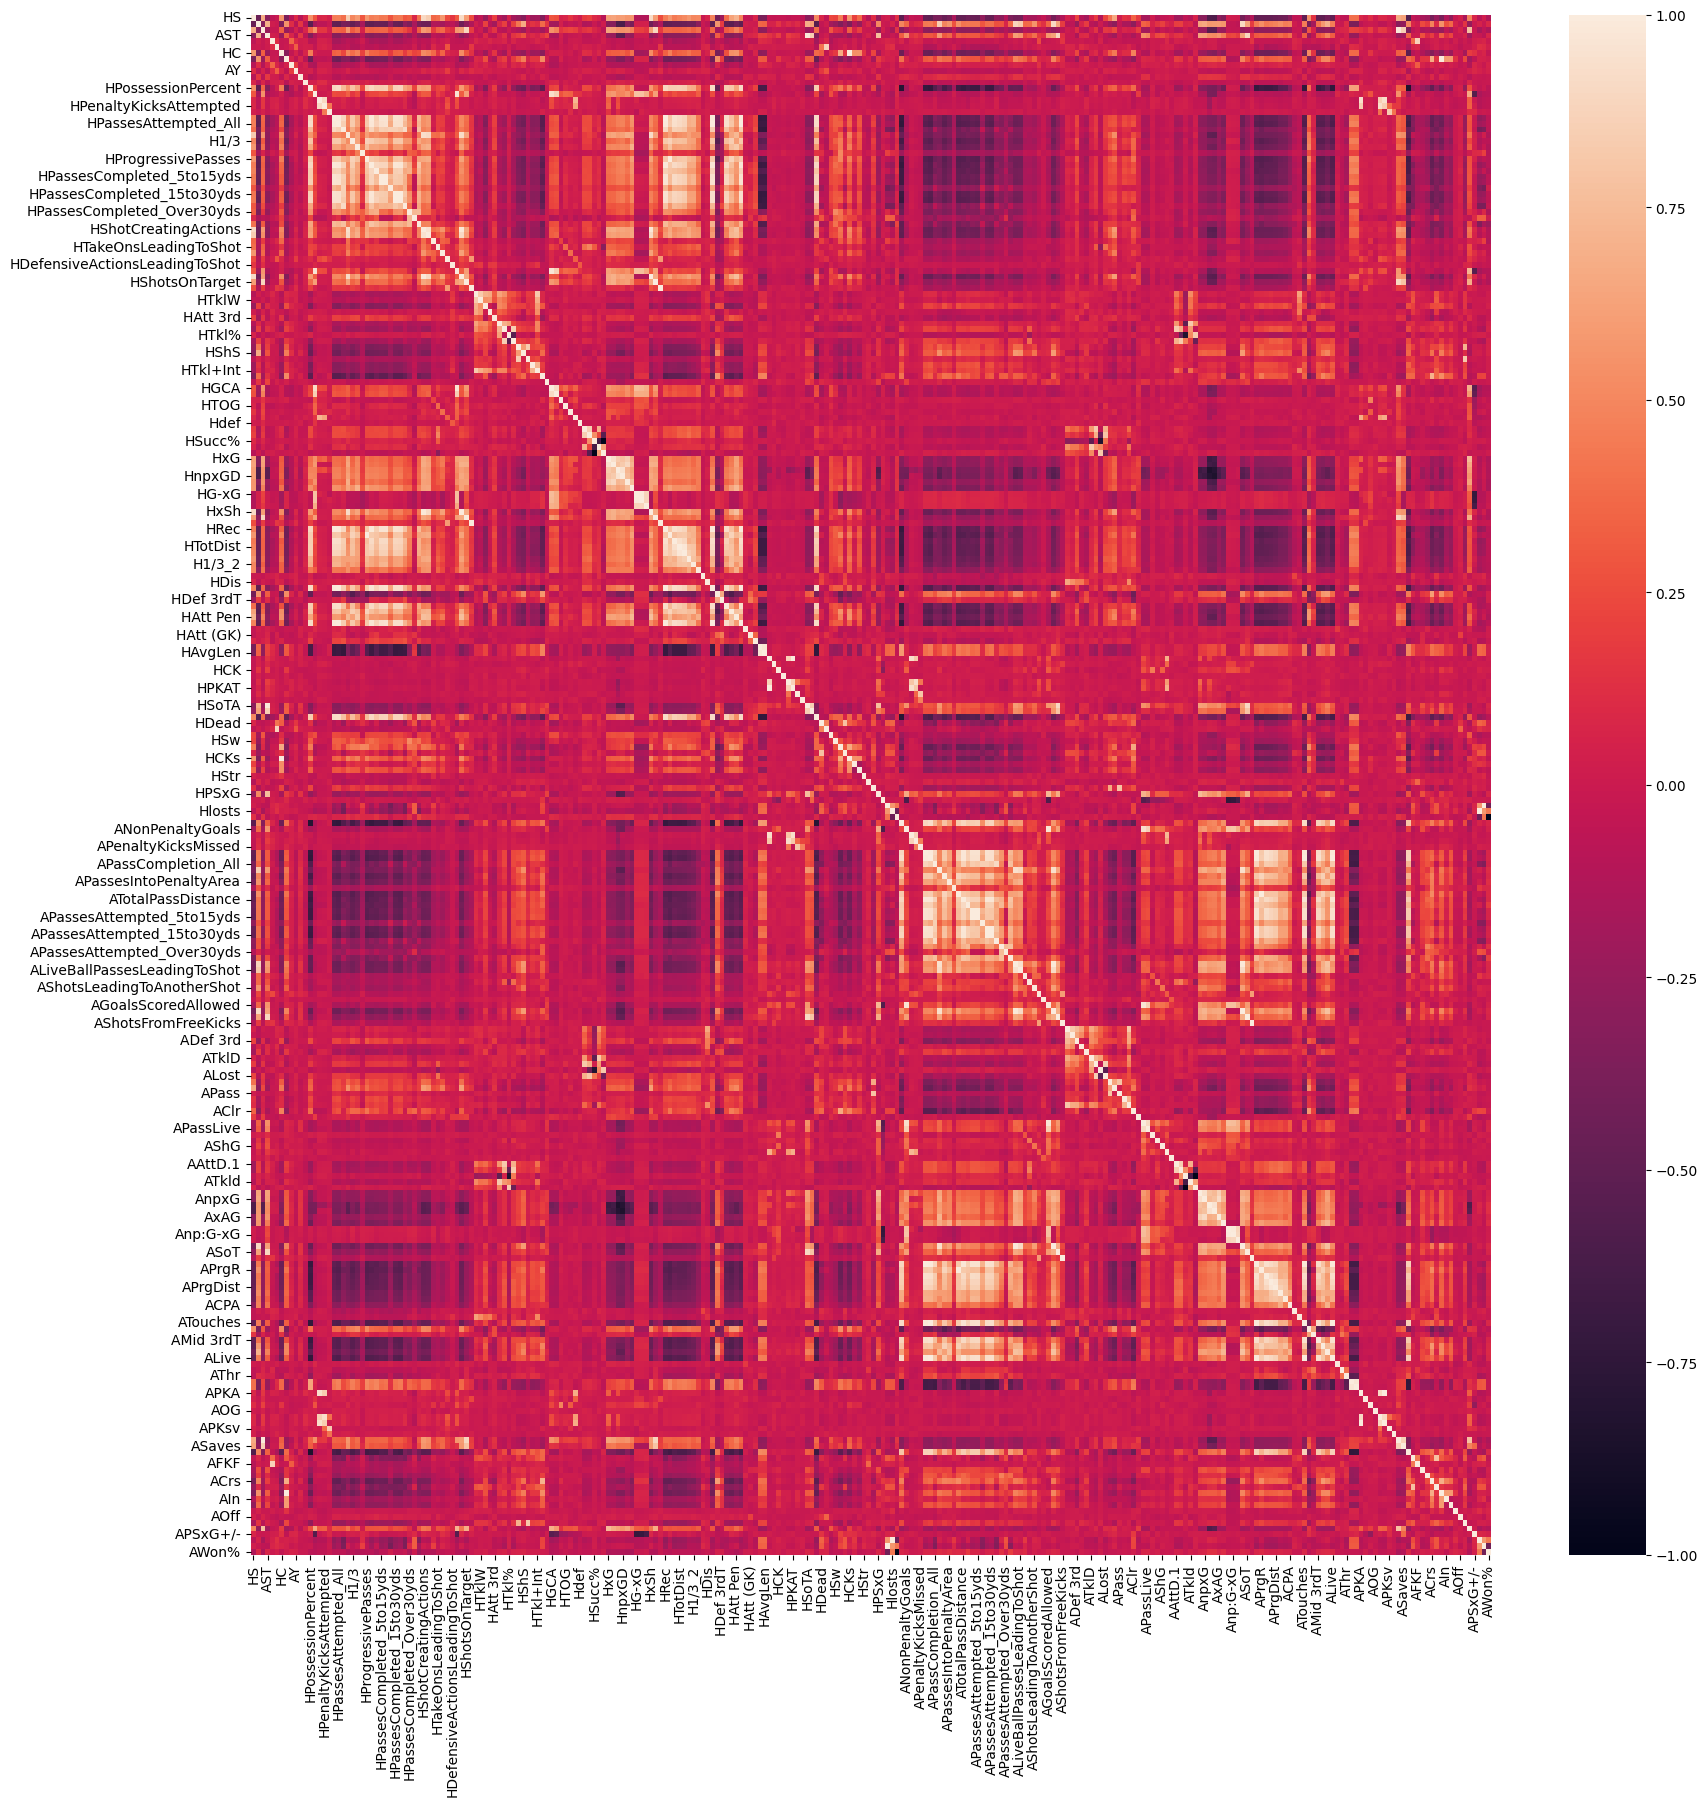

In [ ]:
# Correlation matrix
fig, ax = plt.subplots(figsize=(20, 20))
seaborn.heatmap(
    X_train[numerical_columns].corr(),
    ax=ax,
    vmin=-1.0,
    vmax=1.0,
)
plt.show()

# New Section

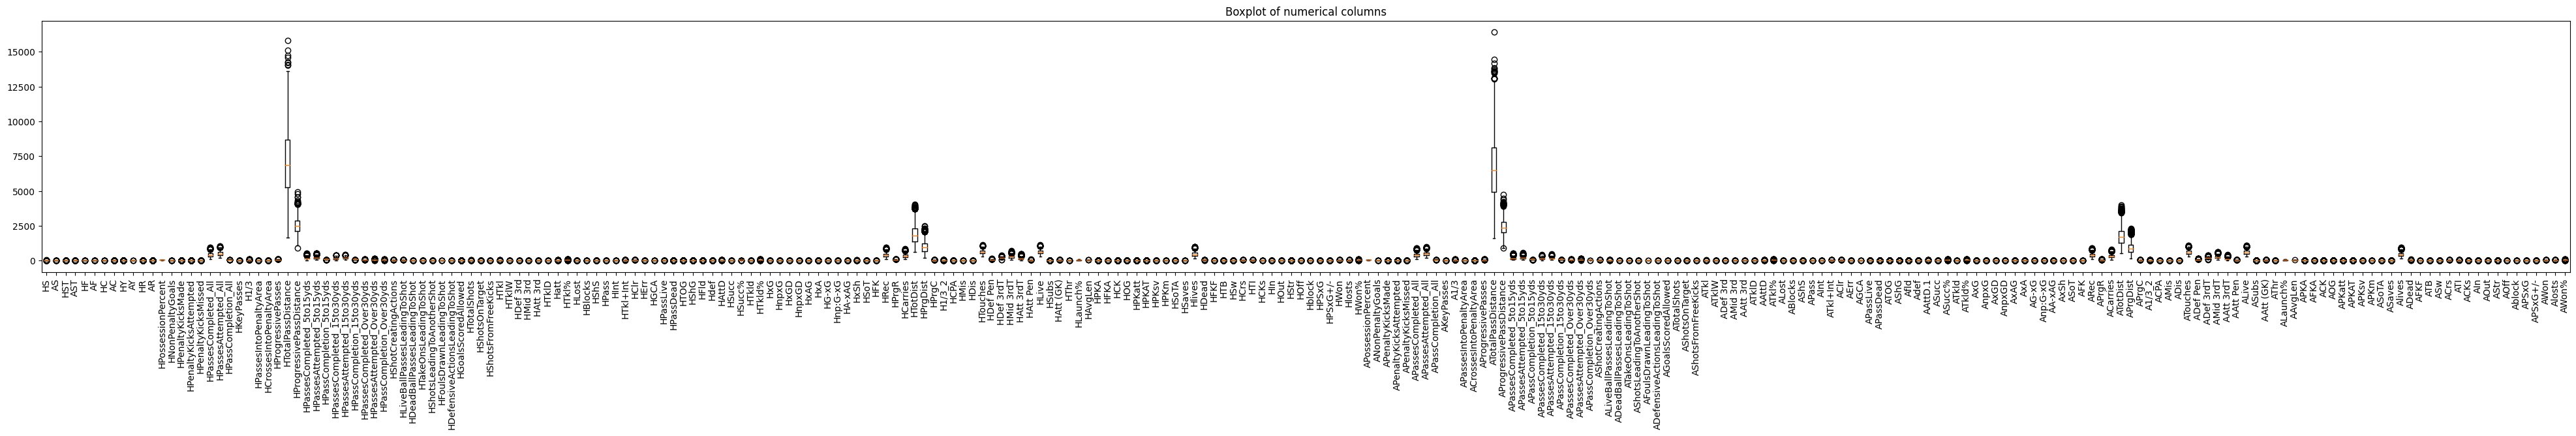

In [ ]:
# Boxplot of the numerical columns
fig, ax = plt.subplots(figsize=(50, 5))
ax.boxplot(data[numerical_columns].values)
ax.set_xticklabels(numerical_columns, rotation=90)
ax.set_title("Boxplot of numerical columns")
plt.show()

In [ ]:
# Standardize the data
scaler = sklearn.preprocessing.StandardScaler()

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])
X_val[numerical_columns] = scaler.transform(X_val[numerical_columns])

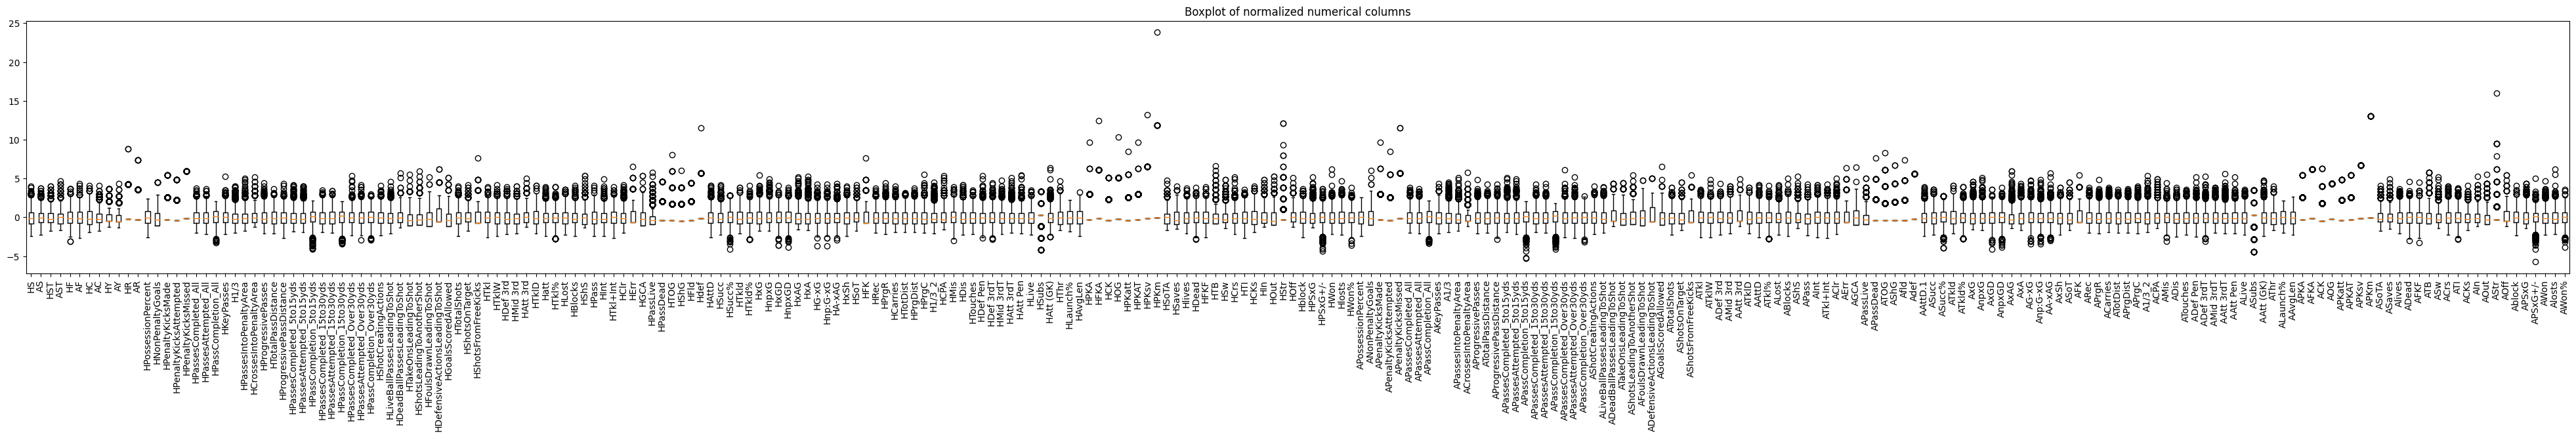

In [ ]:
# Boxplot of the numerical columns
fig, ax = plt.subplots(figsize=(50, 5))
ax.boxplot(X_train[numerical_columns].values)
ax.set_xticklabels(numerical_columns, rotation=90)
ax.set_title("Boxplot of normalized numerical columns")
plt.show()

In [ ]:
# Ensure data types are correct
X_train = numpy.array(X_train, dtype=numpy.float32)
X_test = numpy.array(X_test, dtype=numpy.float32)
X_val = numpy.array(X_val, dtype=numpy.float32)

y_train = numpy.array(Y_train, dtype=numpy.float32)
y_test = numpy.array(Y_test, dtype=numpy.float32)
y_val = numpy.array(Y_val, dtype=numpy.float32)

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(X_val.shape)
print(Y_val.shape)

(1703, 322)
(1703, 3)
(572, 322)
(572, 3)
(361, 322)
(361, 3)


In [ ]:
# Create the model
model = keras.models.Sequential(
    [
        keras.layers.Input(shape=(X_train.shape[1],)),
        keras.layers.Normalization(),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(3, activation="softmax")
    ]
)

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.Accuracy()], jit_compile=False
)

# Train the model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=300,
    batch_size=128,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=20,
            restore_best_weights=True
        )
    ]
)

Epoch 1/300
14/14 [==============================] - 1s 36ms/step - loss: 0.6949 - accuracy: 0.0000e+00 - val_loss: 0.3273 - val_accuracy: 0.0000e+00
Epoch 2/300
14/14 [==============================] - 0s 16ms/step - loss: 0.3507 - accuracy: 0.0000e+00 - val_loss: 0.2173 - val_accuracy: 0.0000e+00
Epoch 3/300
14/14 [==============================] - 0s 16ms/step - loss: 0.1979 - accuracy: 1.9573e-04 - val_loss: 0.1554 - val_accuracy: 0.0000e+00
Epoch 4/300
14/14 [==============================] - 0s 16ms/step - loss: 0.1028 - accuracy: 0.0000e+00 - val_loss: 0.1402 - val_accuracy: 0.0000e+00
Epoch 5/300
14/14 [==============================] - 0s 15ms/step - loss: 0.0479 - accuracy: 1.9573e-04 - val_loss: 0.1277 - val_accuracy: 0.0000e+00
Epoch 6/300
14/14 [==============================] - 0s 17ms/step - loss: 0.0226 - accuracy: 0.0000e+00 - val_loss: 0.1118 - val_accuracy: 0.0000e+00
Epoch 7/300
14/14 [==============================] - 0s 16ms/step - loss: 0.0121 - accuracy: 0.0000e

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 322)               645       
 on)                                                             
                                                                 
 dense (Dense)               (None, 512)               165376    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                        

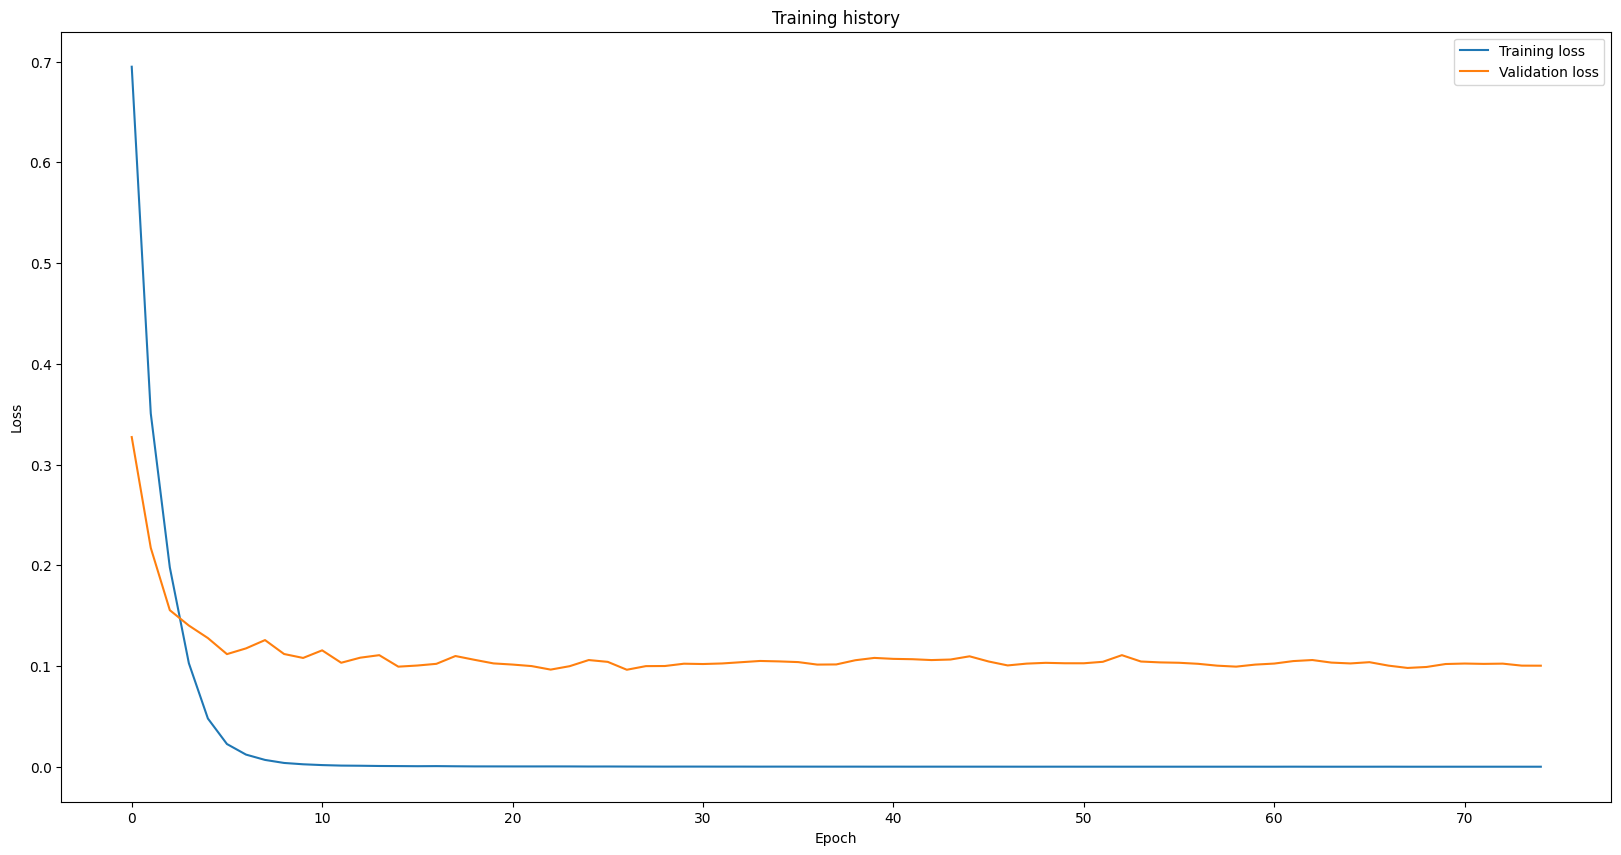

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(history.history["loss"], label="Training loss")
ax.plot(history.history["val_loss"], label="Validation loss")
ax.set_title("Training history")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.show()

12/12 [==============================] - 0s 2ms/step


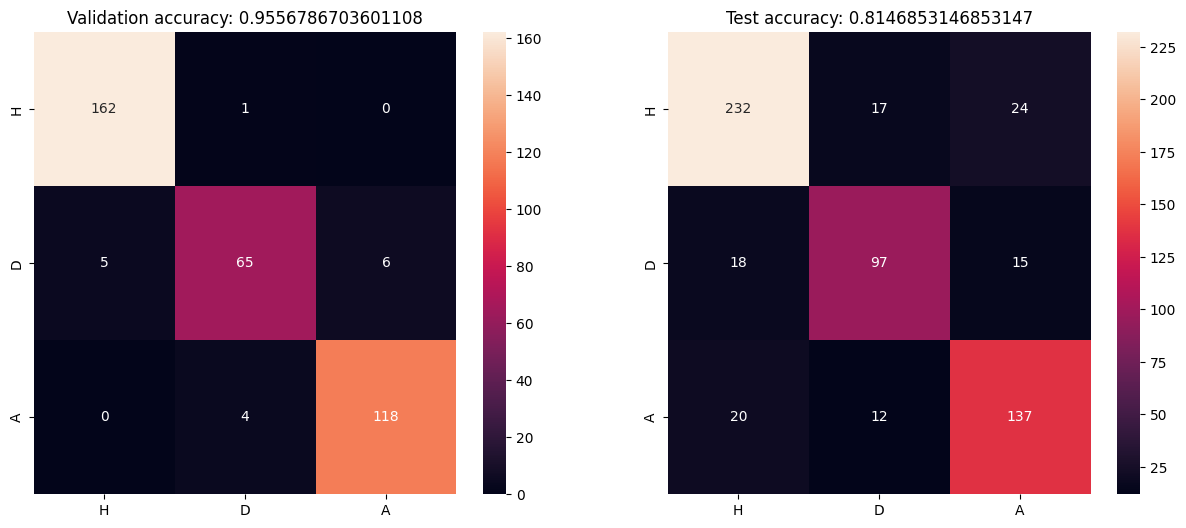

In [ ]:
predictions_test = model.predict(X_test)
predictions_val = model.predict(X_val)

predictions_test = numpy.argmax(predictions_test, axis=1)
predictions_val = numpy.argmax(predictions_val, axis=1)

actual_test = numpy.argmax(Y_test, axis=1)
actual_val = numpy.argmax(Y_val, axis=1)

# Confusion matrix
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 2, 1)
ax.set_title(f"Validation accuracy: {sklearn.metrics.accuracy_score(actual_val, predictions_val)}")
seaborn.heatmap(
    sklearn.metrics.confusion_matrix(actual_val, predictions_val),
    annot=True,
    fmt="d",
    xticklabels=["H", "D", "A"],
    yticklabels=["H", "D", "A"],
    ax=ax
)
ax = fig.add_subplot(1, 2, 2)
ax.set_title(f"Test accuracy: {sklearn.metrics.accuracy_score(actual_test, predictions_test)}")
seaborn.heatmap(
    sklearn.metrics.confusion_matrix(actual_test, predictions_test),
    annot=True,
    fmt="d",
    xticklabels=["H", "D", "A"],
    yticklabels=["H", "D", "A"],
    ax=ax
)
plt.show()


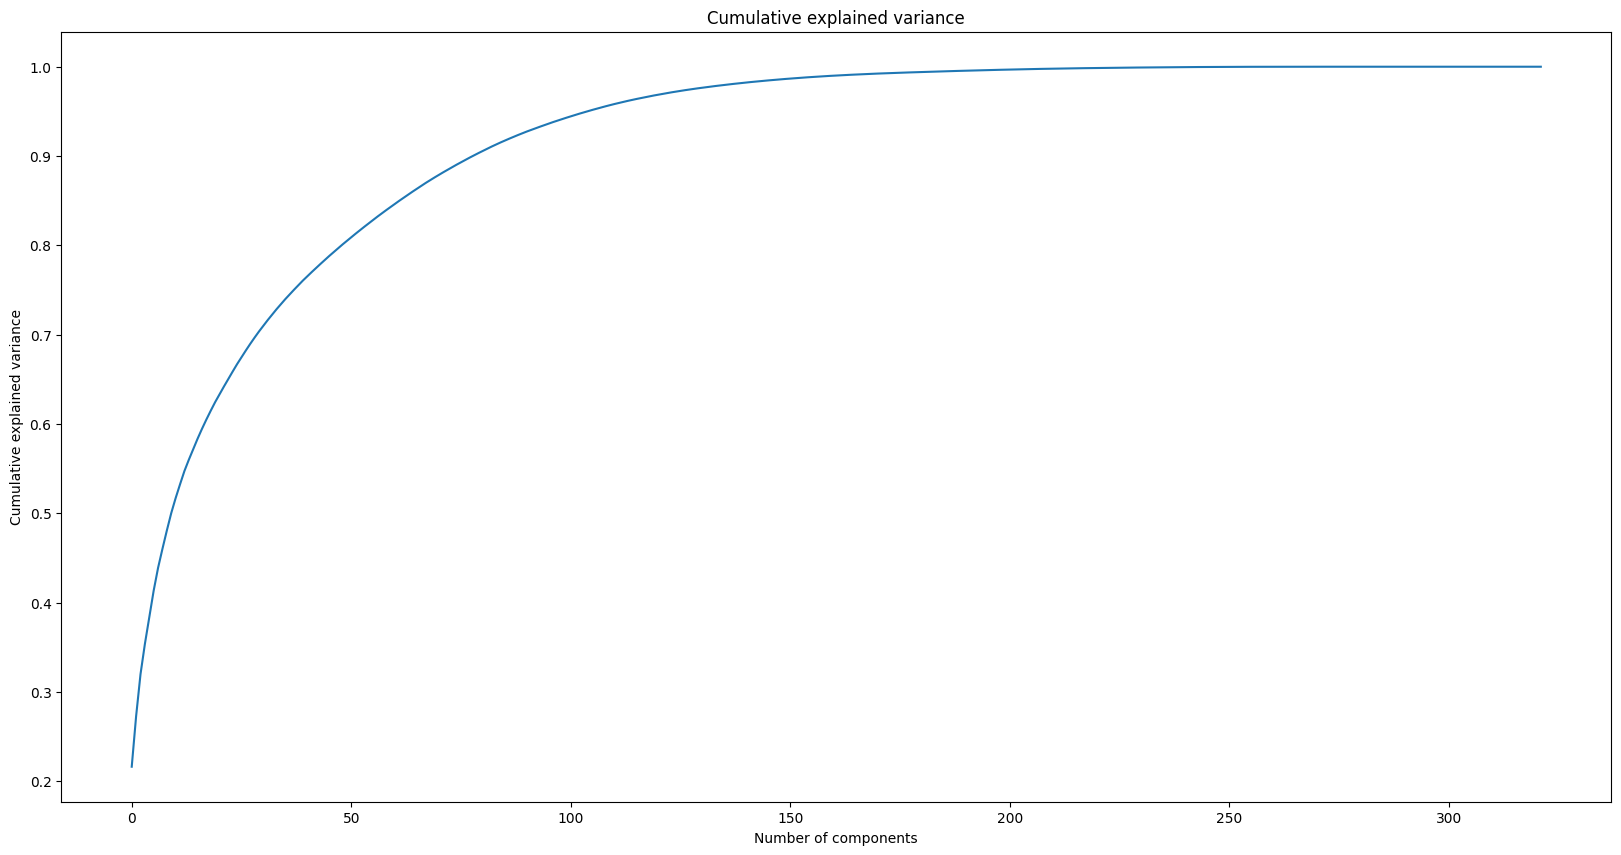

In [ ]:
# PCA
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(numpy.cumsum(pca.explained_variance_ratio_))
ax.set_title("Cumulative explained variance")
ax.set_xlabel("Number of components")
ax.set_ylabel("Cumulative explained variance")
plt.show()

In [ ]:
# We need only 99% variance
top99 = numpy.where(numpy.cumsum(pca.explained_variance_ratio_) > 0.99)[0][0]
print('99% in ' + '%d' % (top99+1) + ' components')

# 95
top95 = numpy.where(numpy.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0]
print('95% in ' + '%d' % (top95+1) + ' components')

# 90
top90 = numpy.where(numpy.cumsum(pca.explained_variance_ratio_) > 0.90)[0][0]
print('90% in ' + '%d' % (top90+1) + ' components')

99% in 161 components
95% in 105 components
90% in 79 components


In [ ]:
transformed_train_99 = pca.transform(X_train)[:, :top99]
transformed_test_99 = pca.transform(X_test)[:, :top99]
transformed_val_99 = pca.transform(X_val)[:, :top99]

print("Train shape: ", transformed_train_99.shape)
print("Test shape: ", transformed_test_99.shape)
print("Validation shape: ", transformed_val_99.shape)

Train shape:  (1703, 160)
Test shape:  (572, 160)
Validation shape:  (361, 160)


In [ ]:
# Train model on PCA
model_pca = keras.models.Sequential(
    [
        keras.layers.Input(shape=(transformed_train_99.shape[1],)),
        keras.layers.Normalization(),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(3, activation="softmax")
    ]
)

model_pca.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.Accuracy()], jit_compile=False,
)

# Train the model
history_pca = model_pca.fit(
    transformed_train_99, Y_train,
    validation_data=(transformed_val_99, Y_val),
    epochs=300,
    batch_size=128,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=20,
            restore_best_weights=True
        )
    ]
)

Epoch 1/300
14/14 [==============================] - 1s 22ms/step - loss: 0.8693 - accuracy: 0.0000e+00 - val_loss: 0.4805 - val_accuracy: 0.0000e+00
Epoch 2/300
14/14 [==============================] - 0s 9ms/step - loss: 0.4003 - accuracy: 0.0000e+00 - val_loss: 0.2745 - val_accuracy: 0.0000e+00
Epoch 3/300
14/14 [==============================] - 0s 9ms/step - loss: 0.2087 - accuracy: 0.0000e+00 - val_loss: 0.1958 - val_accuracy: 0.0000e+00
Epoch 4/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1015 - accuracy: 0.0000e+00 - val_loss: 0.1424 - val_accuracy: 0.0000e+00
Epoch 5/300
14/14 [==============================] - 0s 9ms/step - loss: 0.0392 - accuracy: 1.9573e-04 - val_loss: 0.1206 - val_accuracy: 0.0000e+00
Epoch 6/300
14/14 [==============================] - 0s 9ms/step - loss: 0.0172 - accuracy: 5.8720e-04 - val_loss: 0.1213 - val_accuracy: 0.0000e+00
Epoch 7/300
14/14 [==============================] - 0s 8ms/step - loss: 0.0099 - accuracy: 3.9147e-04 - 

In [ ]:
model_pca.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 160)               321       
 tion)                                                           
                                                                 
 dense_4 (Dense)             (None, 512)               82432     
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 387       
                                                      

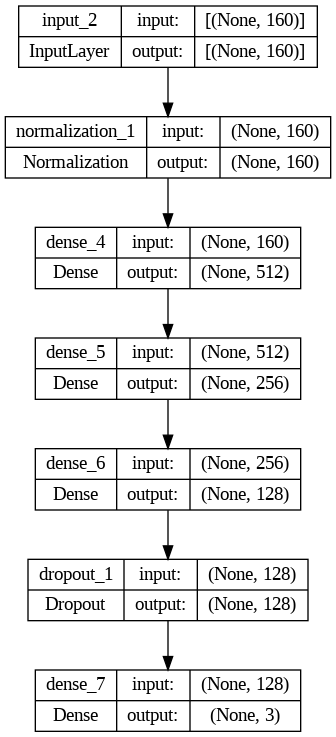

In [ ]:
keras.utils.plot_model(model_pca, show_shapes=True)

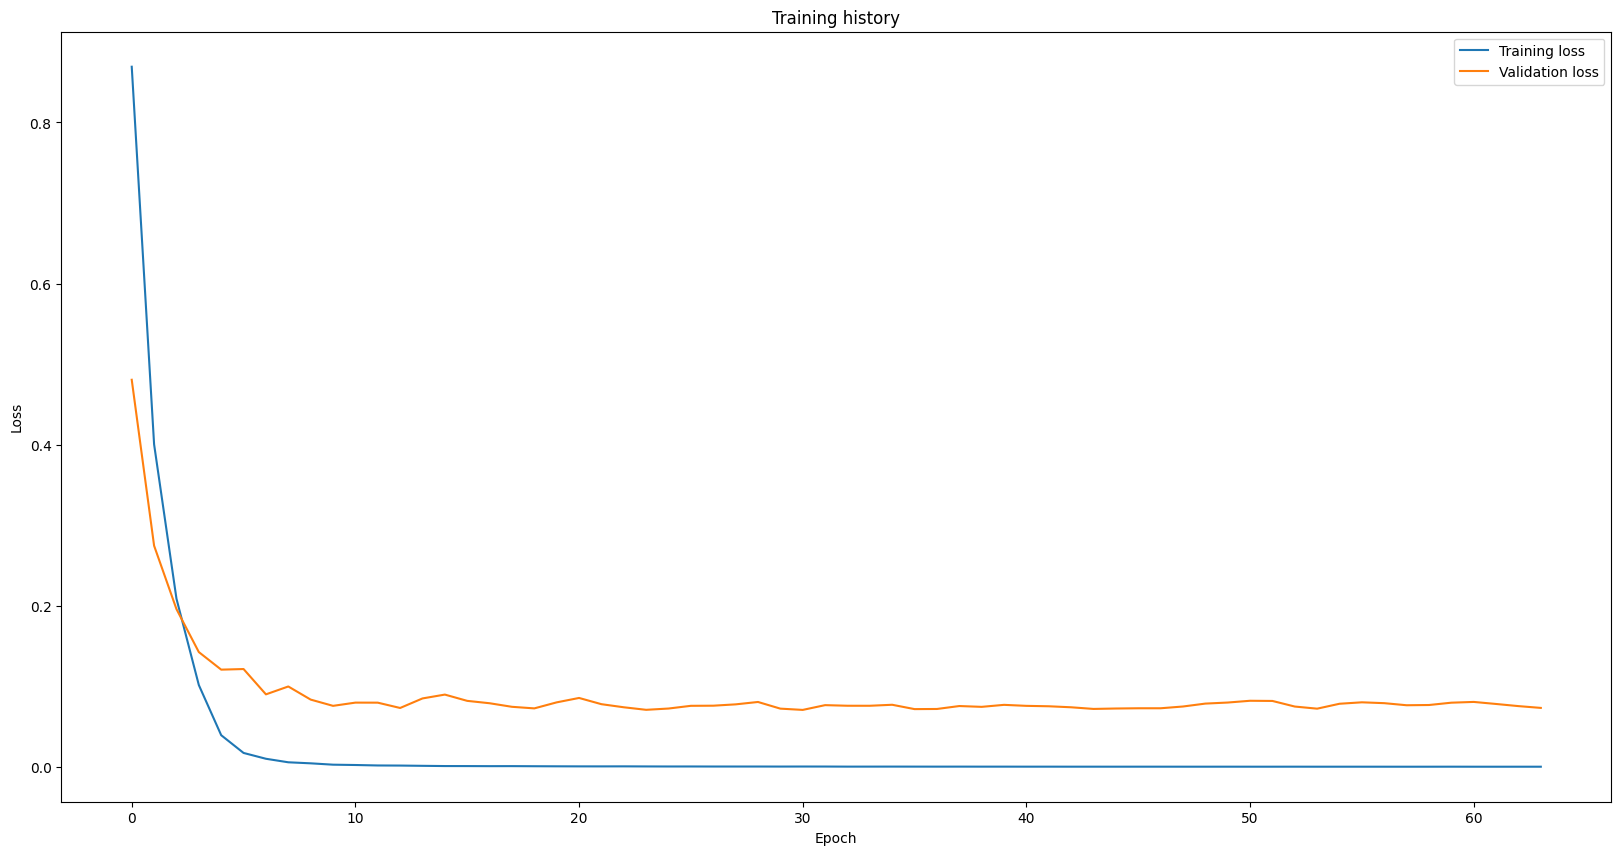

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(history_pca.history["loss"], label="Training loss")
ax.plot(history_pca.history["val_loss"], label="Validation loss")
ax.set_title("Training history")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.show()

12/12 [==============================] - 0s 2ms/step


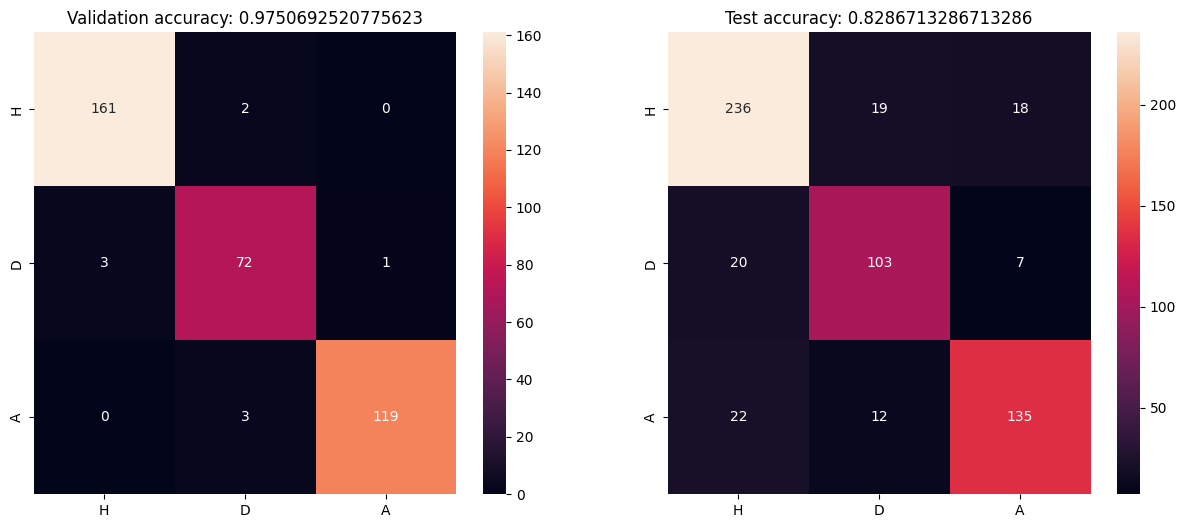

In [ ]:
predictions_test_pca = model_pca.predict(transformed_test_99)
predictions_val_pca = model_pca.predict(transformed_val_99)

predictions_test_pca = numpy.argmax(predictions_test_pca, axis=1)
predictions_val_pca = numpy.argmax(predictions_val_pca, axis=1)

actual_test_pca = numpy.argmax(Y_test, axis=1)
actual_val_pca = numpy.argmax(Y_val, axis=1)

# Confusion matrix
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 2, 1)
ax.set_title(f"Validation accuracy: {sklearn.metrics.accuracy_score(actual_val_pca, predictions_val_pca)}")
seaborn.heatmap(
    sklearn.metrics.confusion_matrix(actual_val_pca, predictions_val_pca),
    annot=True,
    fmt="d",
    xticklabels=["H", "D", "A"],
    yticklabels=["H", "D", "A"],
    ax=ax
)
ax = fig.add_subplot(1, 2, 2)
ax.set_title(f"Test accuracy: {sklearn.metrics.accuracy_score(actual_test_pca, predictions_test_pca)}")
seaborn.heatmap(
    sklearn.metrics.confusion_matrix(actual_test_pca, predictions_test_pca),
    annot=True,
    fmt="d",
    xticklabels=["H", "D", "A"],
    yticklabels=["H", "D", "A"],
    ax=ax
)
plt.show()

In [ ]:
from sklearn import discriminant_analysis
LinearDiscriminantAnalysis = discriminant_analysis.LinearDiscriminantAnalysis().fit(X_train, Y_train.argmax(axis=1))
transformed_lda_train_std = LinearDiscriminantAnalysis.transform(X_train)
transformed_lda_valid_std = LinearDiscriminantAnalysis.transform(X_val)
transformed_lda_test_std = LinearDiscriminantAnalysis.transform(X_test)
print(transformed_lda_train_std.shape, transformed_lda_valid_std.shape, transformed_lda_test_std.shape)

print(transformed_lda_train_std[0])

(1703, 2) (361, 2) (572, 2)
[-4.10806137  1.22874613]


In [ ]:
# Train model on PCA
model_lda = keras.models.Sequential(
    [
        keras.layers.Input(shape=(transformed_lda_train_std.shape[1],)),
        keras.layers.Normalization(),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(3, activation="softmax")
    ]
)

model_lda.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.Accuracy()], jit_compile=False,
)

# Train the model
history_lda = model_lda.fit(
    transformed_lda_train_std, Y_train,
    validation_data=(transformed_lda_valid_std, Y_val),
    epochs=300,
    batch_size=128,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=30,
            restore_best_weights=True
        )
    ]
)

Epoch 1/300
14/14 [==============================] - 2s 32ms/step - loss: 0.5237 - accuracy: 0.0000e+00 - val_loss: 1.3529 - val_accuracy: 0.0000e+00
Epoch 2/300
14/14 [==============================] - 0s 11ms/step - loss: 0.2155 - accuracy: 0.0000e+00 - val_loss: 2.2315 - val_accuracy: 0.0000e+00
Epoch 3/300
14/14 [==============================] - 0s 12ms/step - loss: 0.1833 - accuracy: 0.0000e+00 - val_loss: 1.9189 - val_accuracy: 0.0000e+00
Epoch 4/300
14/14 [==============================] - 0s 14ms/step - loss: 0.1663 - accuracy: 0.0000e+00 - val_loss: 2.0106 - val_accuracy: 0.0000e+00
Epoch 5/300
14/14 [==============================] - 0s 18ms/step - loss: 0.1647 - accuracy: 0.0000e+00 - val_loss: 1.9276 - val_accuracy: 0.0000e+00
Epoch 6/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1525 - accuracy: 0.0000e+00 - val_loss: 1.9293 - val_accuracy: 0.0000e+00
Epoch 7/300
14/14 [==============================] - 0s 12ms/step - loss: 0.1531 - accuracy: 0.0000e

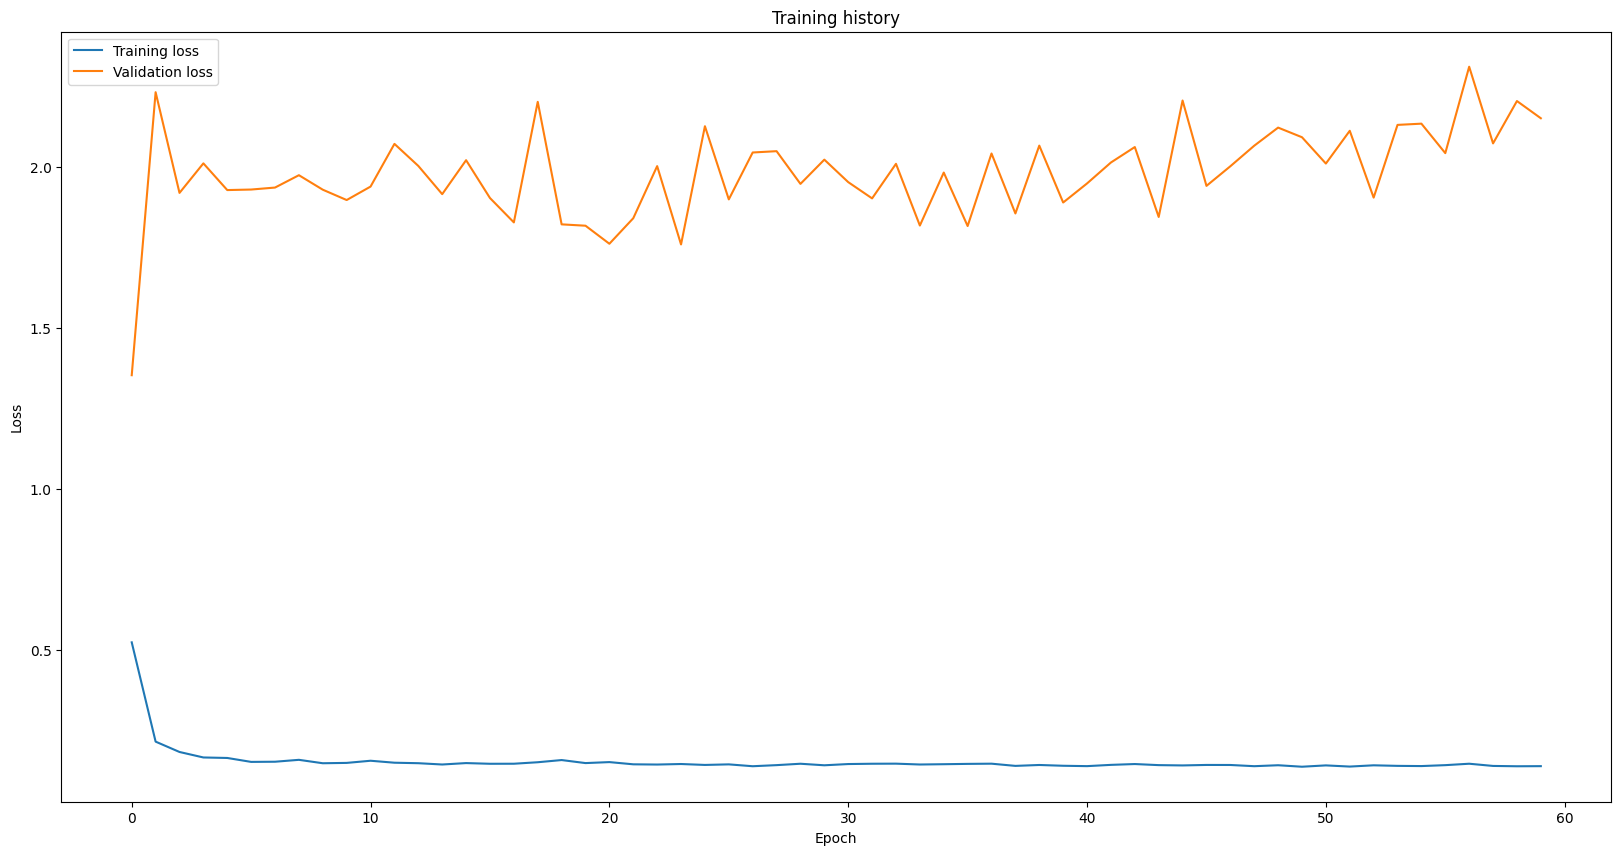

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(history_lda.history["loss"], label="Training loss")
ax.plot(history_lda.history["val_loss"], label="Validation loss")
ax.set_title("Training history")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.show()

12/12 [==============================] - 0s 5ms/step


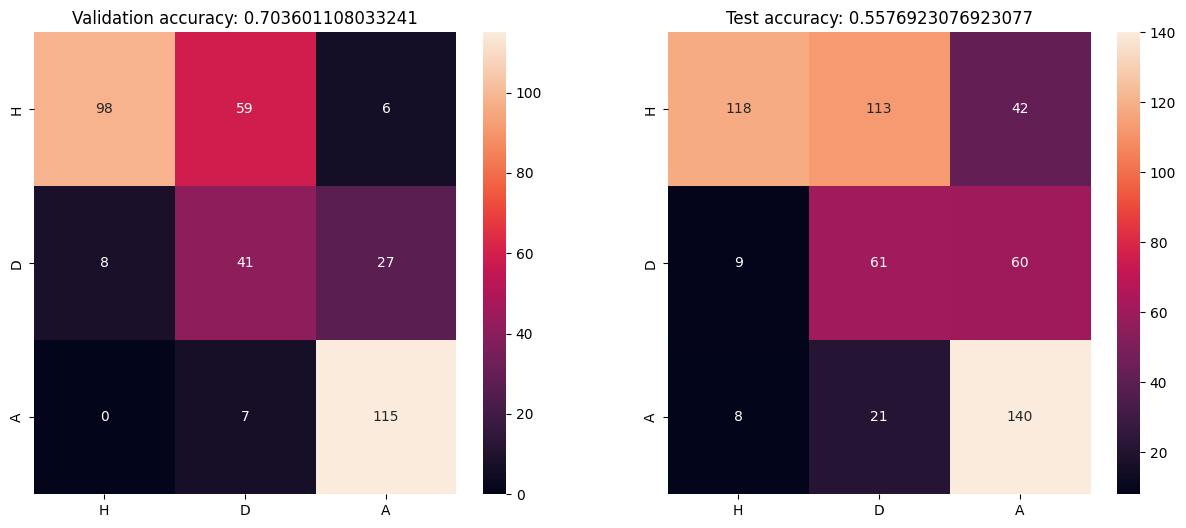

In [ ]:
# Make predictions
predictions_test_lda = model_lda.predict(transformed_lda_test_std)
predictions_val_lda = model_lda.predict(transformed_lda_valid_std)

predictions_test_lda = numpy.argmax(predictions_test_lda, axis=1)
predictions_val_lda = numpy.argmax(predictions_val_lda, axis=1)

actual_test_lda = numpy.argmax(Y_test, axis=1)
actual_val_lda = numpy.argmax(Y_val, axis=1)

# Confusion matrix
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 2, 1)
ax.set_title(f"Validation accuracy: {sklearn.metrics.accuracy_score(actual_val_lda, predictions_val_lda)}")
seaborn.heatmap(
    sklearn.metrics.confusion_matrix(actual_val_lda, predictions_val_lda),
    annot=True,
    fmt="d",
    xticklabels=["H", "D", "A"],
    yticklabels=["H", "D", "A"],
    ax=ax
)
ax = fig.add_subplot(1, 2, 2)
ax.set_title(f"Test accuracy: {sklearn.metrics.accuracy_score(actual_test_lda, predictions_test_lda)}")
seaborn.heatmap(
    sklearn.metrics.confusion_matrix(actual_test_lda, predictions_test_lda),
    annot=True,
    fmt="d",
    xticklabels=["H", "D", "A"],
    yticklabels=["H", "D", "A"],
    ax=ax
)
plt.show()